<a href="https://www.kaggle.com/code/matthewsuri/fast-ai-2?scriptVersionId=195879328" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

My girlfriend and I got into a debate because I thought white ducks and white geese were the same animals. After a quick Google search, I found out that they’re not. But rather than end it there, I decided to build an AI model to tell the difference between ducks, geese, and swans for me!

Huggingface Space App working here: https://huggingface.co/spaces/sum8tt/smallassignment2

In [1]:
# This block checks for internet connectivity in Kaggle notebooks, as you need an active connection to download necessary libraries and datasets.
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# Ensure we're using the latest versions of the fastai and duckduckgo_search libraries.
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

<h1>Searching and downloading images</h1>
To train the model, I need images of ducks, geese, and swans. Instead of manually collecting them, I wrote a function to search for these images online using DuckDuckGo.

In [3]:
#Load our ddg search, fast core, and vision learner items

from duckduckgo_search import DDGS #ddg_images (Deprecated 11-2023)
from fastcore.all import *
from fastai.vision.all import *

In [4]:
# Function to search and download images from DuckDuckGo

def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term,max_results=max_images)).itemgot('image')

In [5]:
# Test the function by searching for a duck image
results = search_images('duck', max_images=1)
results[0]

Searching for 'duck'


'http://upload.wikimedia.org/wikipedia/commons/7/74/White_domesticated_duck,_stretching.jpg'

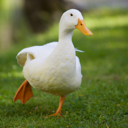

In [6]:
# Download the first duck image and preview it

from fastdownload import download_url

# Set the destination for the downloaded image
destination = 'duck.jpg'
download_url(results[0],destination,show_progress=False)

# Open the downloaded image and show it as a thumbnail
imageExample = Image.open(destination)
imageExample.to_thumb(128,128)

<h1>Preparing the dataset</h1>
Now that I have the search function working, I’ll download images for ducks, geese, and swans. The goal is to gather enough data to train a model that can distinguish between them.

In [7]:
# Define the categories (duck, goose, swan)
waterfowl_types = 'duck', 'goose', 'swan'
path = Path('waterfowl')

In [8]:
# Create a folder to store the images if it doesn't exist
if not path.exists():
    path.mkdir()

In [9]:
# Download images for each waterfowl category
for categories in waterfowl_types:
    categoryDestination = (path/categories)
    categoryDestination.mkdir(exist_ok=True)
    download_images(categoryDestination,urls=search_images(f'white {categories}'))

print('Image download complete.')

Searching for 'white duck'
Searching for 'white goose'
Searching for 'white swan'
Image download complete.


In [10]:
# Check if the images downloaded successfully
fns = get_image_files(path)
fns

(#135) [Path('waterfowl/swan/bee07987-dd38-453a-8260-62fedfa86002.jpg'),Path('waterfowl/swan/1fb53935-2ace-4d5c-bd2e-cf95915d25f7.jpg'),Path('waterfowl/swan/e189e58f-e3bd-48bd-b2d9-9dc8e9ef2595.jpg'),Path('waterfowl/swan/762e07f9-7779-4274-9cbc-bd0d8f06c227.jpg'),Path('waterfowl/swan/d25622d8-1cec-473f-9d21-fe71a9d26a55.jpg'),Path('waterfowl/swan/24abbf93-b509-4c37-a931-43004f27218c.jpg'),Path('waterfowl/swan/df423120-e2d6-495e-bd9f-0aa5af8ccf70.jpg'),Path('waterfowl/swan/a95753a0-3557-45ac-a9f1-ddb375f0c465.jpg'),Path('waterfowl/swan/11489fd7-0293-491a-8bd9-24a0a8643981.jpg'),Path('waterfowl/swan/8614fdd9-927e-49e5-a47b-2836e4078872.jpg')...]

In [11]:
# Verify the images and remove any that are corrupted or invalid
failed = verify_images(fns)
failed

(#2) [Path('waterfowl/duck/8e81b5a8-b137-4882-841e-2fff547cf4fd.jpg'),Path('waterfowl/duck/0a392fba-4511-48e1-b135-ff164109f841.jpg')]

In [12]:
# Remove failed images
failed.map(Path.unlink);
len(failed)

2

<H1>Building the model</h1>
Here’s where the AI model comes in. At first, I used a method called RandomResizedCrop (RRC) to randomly crop the images during training. However, I realized I didn’t want the model to rely on color differences when identifying animals. Instead, I wanted it to focus on their physical characteristics—so I pivoted to using grayscale images!



In [13]:
# Define the DataBlock for loading images
waterfowl = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label, 
    item_tfms=Resize(128)
)

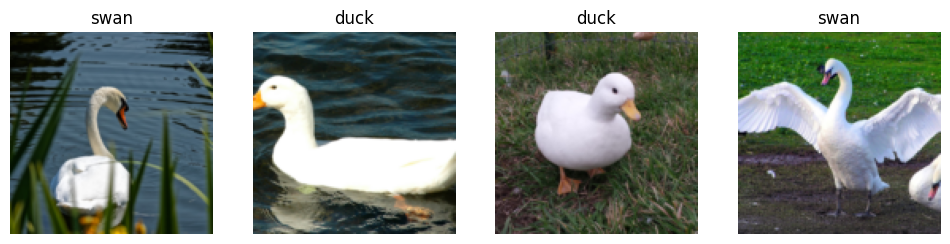

In [14]:
# Load the dataset
dls = waterfowl.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

<h1>Converting images to grayscale</h1>
To ensure the model doesn’t use color as a clue for differentiating the birds, I applied a grayscale transformation to the images.

In [15]:
# Create a custom transformation to convert images to grayscale
class GrayscaleTransform(Transform):
    def encodes(self, img: PILImage):  # Apply the transformation during encoding
        return img.convert("L")  # Convert the image to grayscale (L mode is for black-and-white)

In [16]:
# Define the DataBlock with the custom grayscale transformation
waterfowl_grayscale = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(128), GrayscaleTransform()],  # Resize and apply grayscale
    batch_tfms=aug_transforms()  # Data augmentation
)

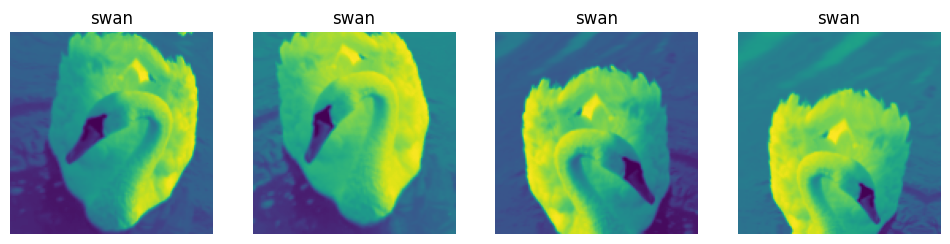

In [17]:
# Load the DataLoader with grayscale images
dls_grayscale = waterfowl_grayscale.dataloaders(path)
dls_grayscale.train.show_batch(max_n=4, nrows=1, unique=True)

<h1>Training the AI model</h1>
I trained a ResNet18 model using the grayscale images. This convolutional neural network is well-suited for image classification tasks.

In [18]:
# Train the learner using ResNet18 and grayscale images
learn = vision_learner(dls_grayscale, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 47.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.925333,8.277540,0.692308,00:06


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.753193,6.439283,0.692308,00:06
1,1.893738,5.096955,0.653846,00:06
2,1.892193,4.258073,0.615385,00:05
3,1.839765,3.576785,0.576923,00:06
4,1.726514,3.279578,0.500000,00:06
5,1.599568,3.038212,0.500000,00:05
6,1.474880,2.884210,0.500000,00:05
7,1.358153,2.695250,0.500000,00:06
8,1.262919,2.533140,0.500000,00:05
9,1.180216,2.312495,0.461538,00:06


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes sh

<h1>Evaluating the model</h1>
After training the model, I evaluated its performance by visualizing the confusion matrix and analyzing where the model made mistakes. See, even the model was confused sometimes.

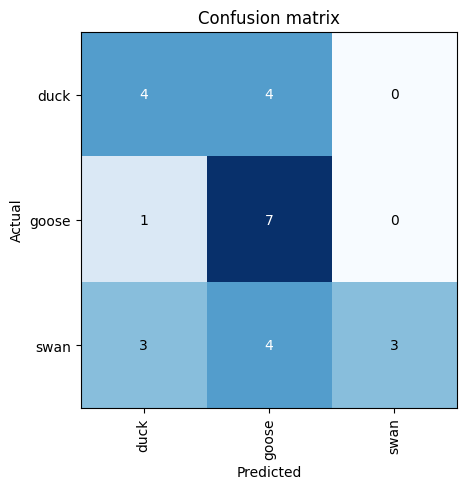

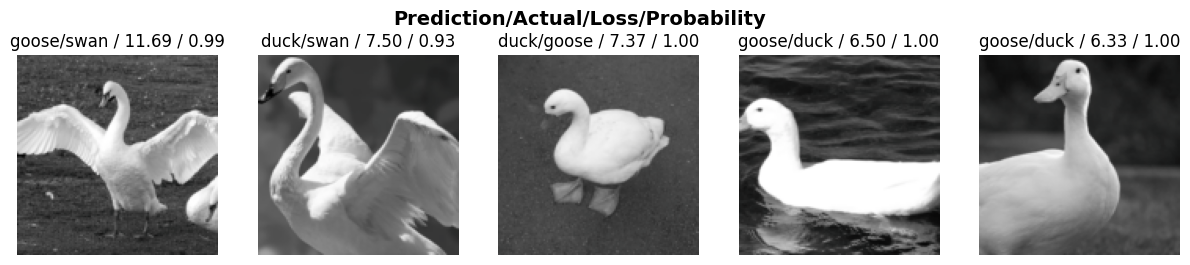

In [19]:
# Model interpretation: confusion matrix and top losses
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)

In [20]:
#clean the data set
from fastai.vision.widgets import ImageClassifierCleaner

# Model is already trained and 'learn' is the learner object
cleaner = ImageClassifierCleaner(learn)

# Show the cleaner widget
cleaner

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [21]:
#make changes to the data set
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

<h1>Making predictions</h1>
Finally, I tested the model by asking it to predict whether an image was of a duck, goose, or swan. The results were impressive!

In [22]:
# Make a prediction on the downloaded 'duck.jpg' image
is_duck, _, probs = learn.predict(PILImage.create('duck.jpg'))
print(f"This waterfowl is: {is_duck}.")
print(f"Probability it's a duck: {probs[0]:.4f}")

This waterfowl is: duck.
Probability it's a duck: 0.9457


In [23]:
#Export model
learn.export('export.pkl')

In [24]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

<a href="export.pkl"> Download File </a>

<h1>Conclusion</h1>
In the end, my AI model confirmed what Google had already told me: white ducks and white geese are not the same animals. But now, I have a cool AI tool that can tell the difference between ducks, geese, and swans with great accuracy!